# Basic System Evaluation

To fully understand the task, and the difficulties, I'll run one pass of evaluation in this NB. After the initial exploration, we can productionize this code.

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot

# Imports
import sklearn
from sklearn.metrics import average_precision_score
import numpy as np
import random
import copy
from os import path
import jinja2
from IPython.display import display, HTML
template_dir = path.abspath('../html')
loader = jinja2.FileSystemLoader(template_dir)
environment = jinja2.Environment(loader=loader)


def apk(actual, predicted, k=None):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if k is None:
        k = len(predicted)
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

sub_tasks = ['celebrity', 'movie', 'restaurant', 'tvShow']
trainset_locs = map(path.abspath, ['../data/TRAIN SET/%s.TRAINSET.txt' % t for t in sub_tasks])
devset_locs = map(path.abspath, ['../data/DEV SET/%s.DEVSET.txt' % t for t in sub_tasks])
output_locs = map(path.abspath, ['../output/%s.txt' % t for t in sub_tasks])

In [2]:
# loading datasets
def LoadInData(data_loc, test_data=False):
    lines = unicode(open(data_loc).read(), 'gbk').split('\n')
    parsing_result = []
    for line in lines:
        terms = line.split('\t')
        items = []
        for i in terms[1:]:
            if test_data:
                ent, score = i, None

            else:
                colon_separated = i.split(':')
                ent = ':'.join(colon_separated[:-1])
                score = int(colon_separated[-1])
            items.append((ent, score))
        if len(items) == 0:
            continue
        parsing_result.append((terms[0], items))
    return parsing_result


# take celebrity as example
cel_train_data = LoadInData(trainset_locs[0])

# Basic strategies, and how to evaluate

def NoReorder(q, results):
    return results

def Reversed(q, results):
    return list(reversed(results))


def EvaluateByRank(strategy, seed=None, train_data=cel_train_data, title="", export_report_at=None):
    if seed is None:
        seed = random.Random()
    score_results = []
    
    report_data = {"query_results" : [], "title" : title}
    
    for q_id, (query, gs_result) in enumerate(train_data):
        shuffled_result = copy.copy(gs_result)
        seed.shuffle(shuffled_result)
        my_result = strategy(query, [i for (i, t) in shuffled_result])
        gs_result = [i for i, t in gs_result if t == 1]
        
        report_item = {"term" : query, "ranked" : [], "id" : q_id}
        for r in my_result:
            report_item['ranked'].append(
                {'is_gs' : (r in gs_result), 'entity' : r})
        map_score = apk(gs_result, my_result, len(shuffled_result))
        report_item['MAP'] = map_score
        report_data["query_results"].append(report_item)
        
        score_results.append(map_score)
    
    map_value = sum(score_results) / len(score_results)
    
    report_data['map_value'] = map_value
    if export_report_at is not None:
        with open(export_report_at, 'w') as ofile:
            html = environment.get_template('error_analysis.html').render(report_data)
            ofile.write(html.encode('utf8'))
    
    return map_value

def EvaluateAllByRank(strategy, seed=None):
    if seed is None:
        seed = random.Random()
    result = {}
    for sub_task, train_loc in zip(sub_tasks, trainset_locs):
        train_data = LoadInData(train_loc)
        result[sub_task] = EvaluateByRank(strategy, seed, train_data)
    return result

print EvaluateAllByRank(NoReorder)
print EvaluateAllByRank(Reversed)

{'movie': 0.2579528903376031, 'celebrity': 0.15605630837451168, 'tvShow': 0.14917328737283278, 'restaurant': 0.18849488978184173}
{'movie': 0.24982960393759132, 'celebrity': 0.1565680645512637, 'tvShow': 0.16502675171474382, 'restaurant': 0.19067002133108893}


In [3]:
def OrderByScore(func):
    def wrappee(q, results):
        return [r for s, r in sorted([
                    (func(q, r), r) for r in results
                ], reverse=True)]
    return wrappee

# Try a real metric
@OrderByScore
def CharOverlap(q, r):
    return len(set(q).intersection(set(r)))

print EvaluateAllByRank(CharOverlap)

{'movie': 0.32330062464220133, 'celebrity': 0.32605351222452034, 'tvShow': 0.22679582987293437, 'restaurant': 0.2338259004008226}


In [4]:
# exporting results into a file

def ExportResultsWithStrategy(strategy):
    for output_filename, testdata_loc in zip(output_locs, devset_locs):
        testdata = LoadInData(testdata_loc, test_data=True)
        with open(output_filename, 'w') as ofile:
            for query, entries in testdata:
                my_result = strategy(query, [i for (i, t) in entries])
                print >> ofile, '\t'.join([query] + my_result).encode('gbk')
            
ExportResultsWithStrategy(CharOverlap)

## Influence of Cutoff
Cutoff can have a big influence. Intuitively, if the first a couple of retrieval results are accurate enough, it's not necessary to include the other ones. Besides, the current submission or restaurants exceeds the size limit. How does cutoff have influence on output?

In [5]:
def BuildCutoffStrategy(strategy, cutoff):
    def wrappee(*args, **kw):
        result = strategy(*args, **kw)
        return result[:cutoff]
    return wrappee

results = sc.parallelize(range(1, 101)).map(lambda i: EvaluateAllByRank(BuildCutoffStrategy(CharOverlap, i))).collect()

/home/bighead/.local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/bighead/.local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


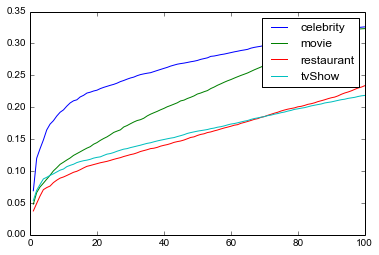

In [6]:
def PlotForTask(name):
    pyplot.plot(range(1, 101), [i[name] for i in results], label=name)
    
for name in sub_tasks:
    PlotForTask(name)
pyplot.legend()

In [7]:
print results[90]
ExportResultsWithStrategy(BuildCutoffStrategy(CharOverlap, 90))

{'movie': 0.3100694834246548, 'celebrity': 0.31885806263176003, 'restaurant': 0.21593732500032492, 'tvShow': 0.2095671190443939}


It seems with the current strategy, it's always better to submit more results.

# Exporting Results for Error Analysis

Currently we only get a wholistic score. To improve our system, we will need ways to export errors made by the system, and analyze it. Printing the error analysis report will do.

In [51]:
template = environment.get_template('error_analysis.html')
display(HTML(template.render({
                "query_results" : [{"term" : "good person",
                                    "MAP" : 0.8,
                                   "ranked" : [{"is_gs" : True, "entity" : "Huichao Xue"},
                                               {"is_gs" : False, "entity" : "Miao Zhou"},
                                               {"is_gs" : True, "entity" : "Yafei Wei"},
                                              ]}]
            })))

Query Ind,Query term,MAP,Ranking Results
,good person,0.8,"1: Huichao Xue , 2: Miao Zhou , 3: Yafei Wei"


In [70]:
EvaluateByRank(CharOverlap, export_report_at='../reports/char_overlap_celebrity.html', title="CharOverlap on celebrities")

0.32605351222452034